In [1]:
from itertools import product as product
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from math import sqrt as sqrt
import matplotlib.pyplot as plt


class PriorBox(object):
    def __init__(self):
        super(PriorBox, self).__init__()
        self.image_size = 300
        self.feature_maps = [38, 19, 10, 5, 3, 1]
        self.steps = [8, 16, 32, 64, 100, 300]
        self.min_sizes = [30, 60, 111, 162, 213, 264]
        self.max_sizes = [60, 111, 162, 213, 264, 315]
        self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    def forward(self):
        mean = []
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k]
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
        print(torch.Tensor(mean).shape)
        output = torch.Tensor(mean).view(-1, 4)
        print(output.shape)
        output.clamp_(max=1, min=0)
        return output

In [2]:
dbox = PriorBox()
d_box_list = dbox.forward()
box_coordinate = np.zeros((len(d_box_list), 4, 2))

torch.Size([34928])
torch.Size([8732, 4])


In [3]:
for i in range(len(d_box_list)):
    box_coordinate[i][0] = d_box_list[i][:2] + np.array([-d_box_list[i][2]/2, -d_box_list[i][3]/2])
    box_coordinate[i][1] = d_box_list[i][:2] + np.array([-d_box_list[i][2]/2, d_box_list[i][3]/2])
    box_coordinate[i][2] = d_box_list[i][:2] + np.array([d_box_list[i][2]/2, d_box_list[i][3]/2])
    box_coordinate[i][3] = d_box_list[i][:2] + np.array([d_box_list[i][2]/2, -d_box_list[i][3]/2])




In [4]:
feature_maps = [38, 19, 10, 5, 3, 1]
number_of_boxes = [4, 6, 6, 6, 4, 4]
number_of_boxes_in_each_feature_map = [feature_maps[i]*2 * number_of_boxes[i] for i in range(len(number_of_boxes))]

In [5]:
list_of_dbox_numbers = [feature_maps[i]**2 * number_of_boxes[i] for i in range(len(feature_maps))]

In [6]:
number_of_dboxes_accumulated = []

for i in range(len(list_of_dbox_numbers)):
    number_of_dboxes_accumulated.append(sum(list_of_dbox_numbers[:i]) + list_of_dbox_numbers[i])
    
number_of_dboxes_accumulated = [0] + number_of_dboxes_accumulated

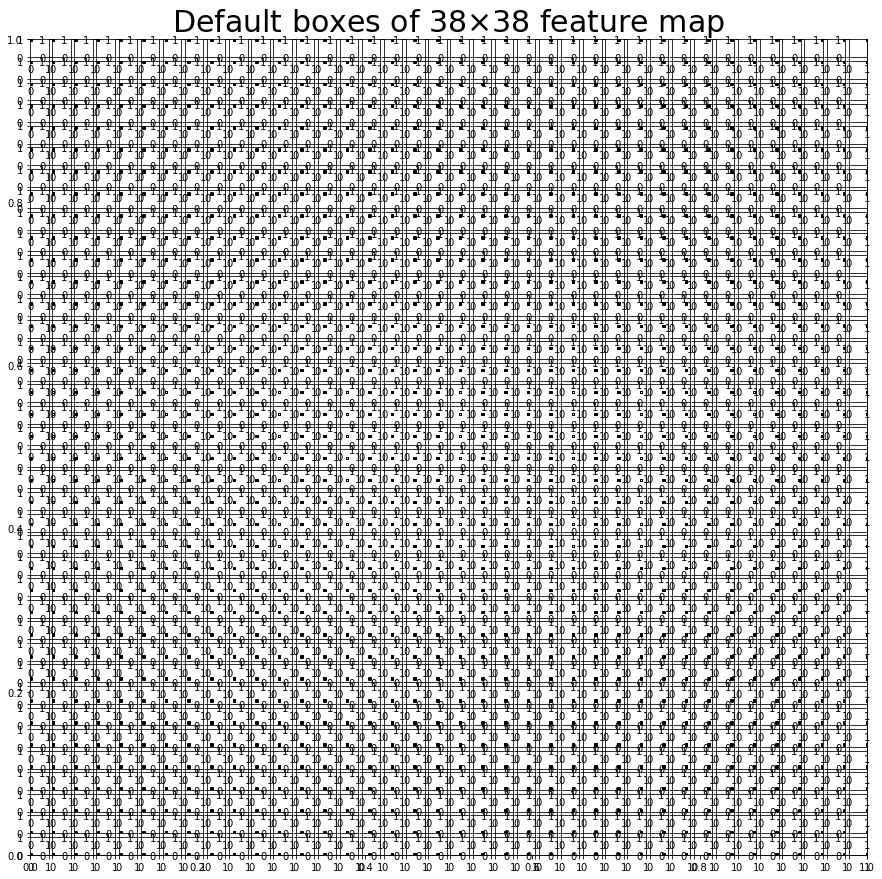

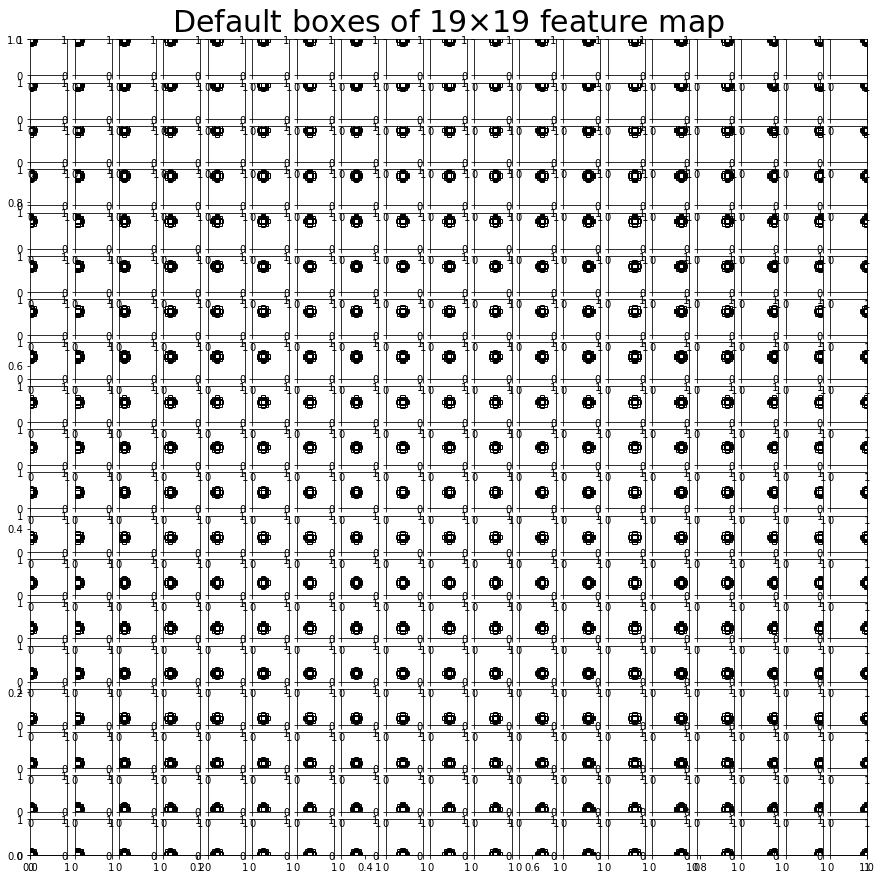

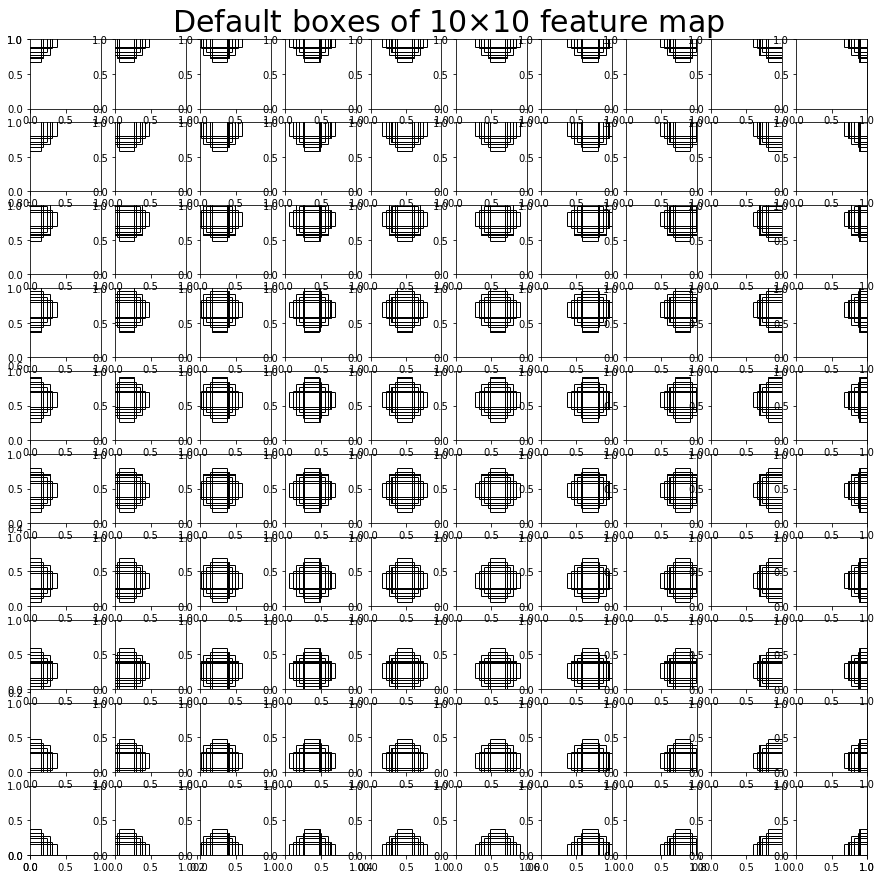

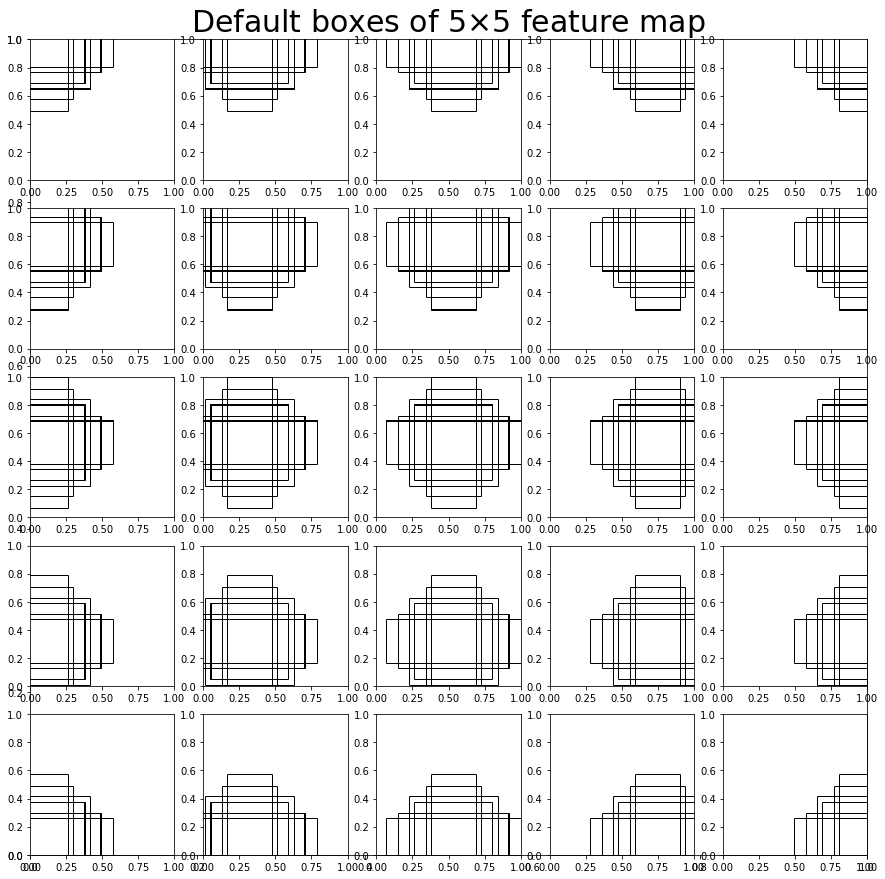

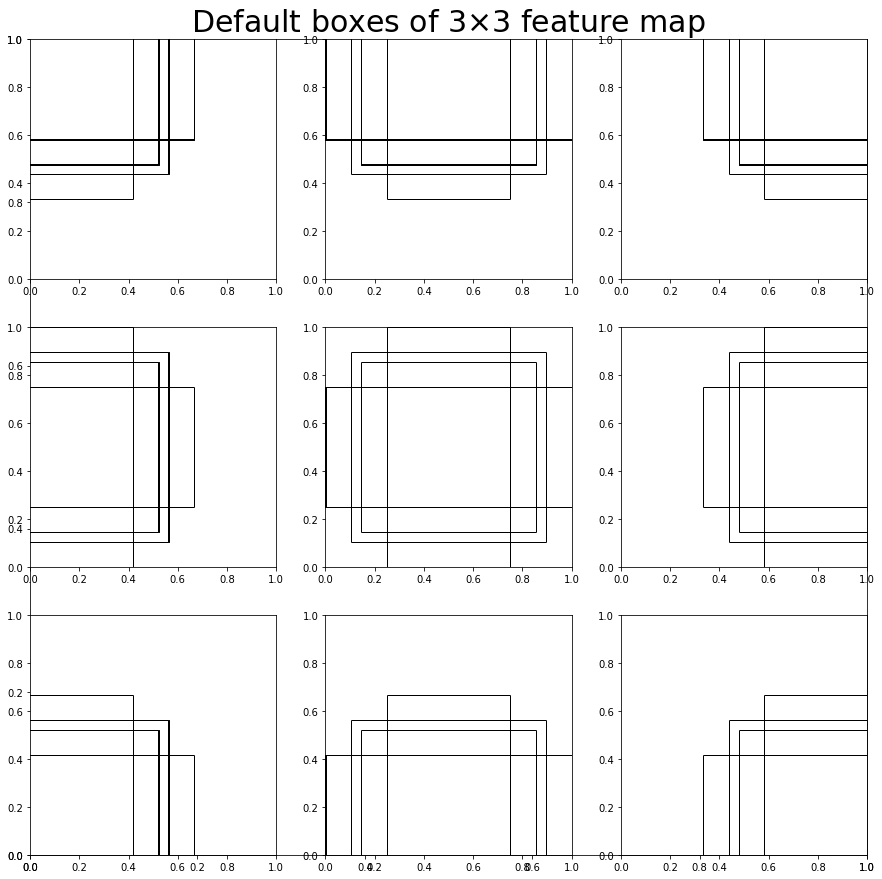

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


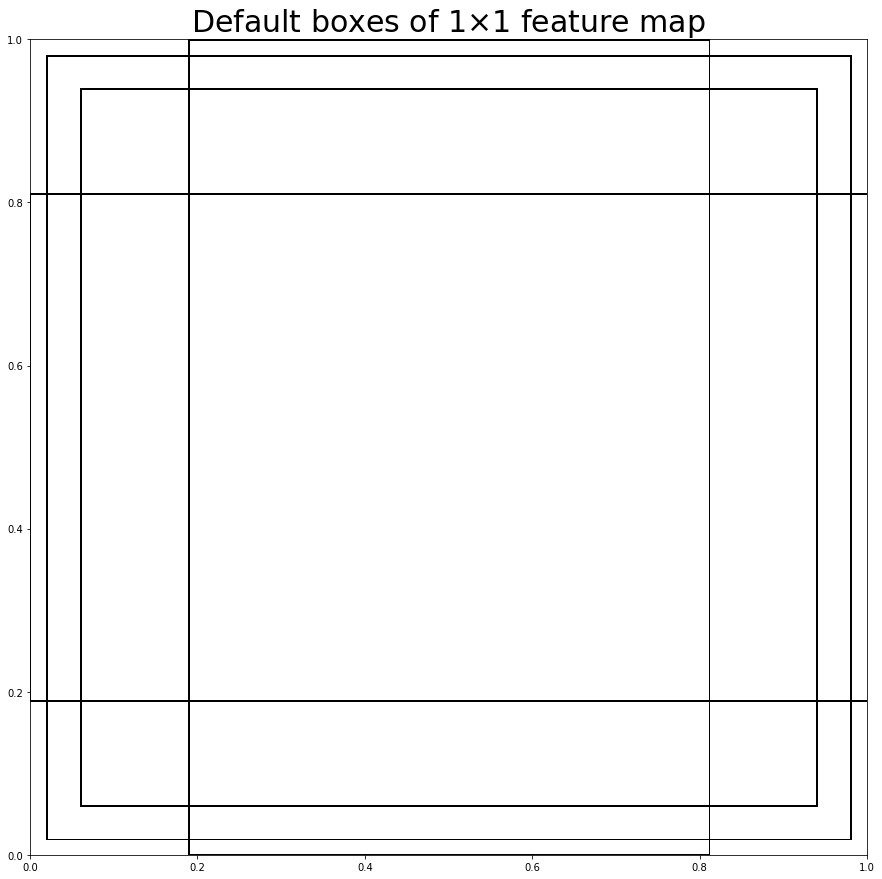

In [7]:
for k in range(len(feature_maps)):
    fig = plt.figure(figsize=(15, 15))
    subplot_location = np.flip(np.arange(feature_maps[k]*feature_maps[k]).reshape(feature_maps[k], feature_maps[k]), axis=0)
    plt.title(r"Default boxes of {}$\times${} feature map".format(feature_maps[k], feature_maps[k]), fontsize=30)

    for idx, i in enumerate(range(number_of_dboxes_accumulated[k], number_of_dboxes_accumulated[k+1], number_of_boxes[k])):
        ax = fig.add_subplot(feature_maps[k], feature_maps[k], subplot_location.reshape(subplot_location.size)[idx] + 1)
        for j in range(number_of_boxes[k]):
            ax.arrow(box_coordinate[i+j][0][0], box_coordinate[i+j][0][1], box_coordinate[i+j][1][0]-box_coordinate[i+j][0][0], box_coordinate[i+j][1][1]-box_coordinate[i+j][0][1], width=0.001, head_width=0, color='black')
            ax.arrow(box_coordinate[i+j][1][0], box_coordinate[i+j][1][1], box_coordinate[i+j][2][0]-box_coordinate[i+j][1][0], box_coordinate[i+j][2][1]-box_coordinate[i+j][1][1], width=0.001, head_width=0, color='black')
            ax.arrow(box_coordinate[i+j][2][0], box_coordinate[i+j][2][1], box_coordinate[i+j][3][0]-box_coordinate[i+j][2][0], box_coordinate[i+j][3][1]-box_coordinate[i+j][2][1], width=0.001, head_width=0, color='black')
            ax.arrow(box_coordinate[i+j][3][0], box_coordinate[i+j][3][1], box_coordinate[i+j][0][0]-box_coordinate[i+j][3][0], box_coordinate[i+j][0][1]-box_coordinate[i+j][3][1], width=0.001, head_width=0, color='black')
        ax.set_xlim(0, 1)    
        ax.set_ylim(0, 1)
    plt.savefig('dbox_visualization_{}.png'.format(feature_maps[k]))
    plt.show()